In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("/home/hofmann/nngame/package/src/rlbase/")

import misc
import env_blackjack
import policy
import agent
from experiment import *

from tqdm.notebook import tqdm

# Figure 5.1
Approximate state-value functions for the blackjack policy that sticks only on 20 or 21, computed by Monte Carlo policy evaluation

In [ ]:
env = env_blackjack.BlackjackEnvironment()
pi = policy.DeterministicPolicy(env=env,best_actions={s:[s[0]<20] for s in env.states})
ag = agent.BaseAgent(env=env,pi=pi)
ex = MC_EveryVisitExperiment(env=env,agent=ag,n_episodes=500000)
ex.train()

In [ ]:
# Dealer-Label
dealer_label = ["A"]+list(range(2,11))

player, dealer = env.get_player_dealer()

# Plot
plt.figure()
arr = np.zeros((len(player),len(dealer),2))
for (ix,x) in enumerate(dealer):
  for (iy,y) in enumerate(player):
    for j in range(2):
      if x==11:
        arr[iy,0,j] = ex.V[(y,x,j)]
      else:
        arr[iy,ix+1,j] = ex.V[(y,x,j)]        
plt.subplot(1,2,1)
plt.imshow(arr[:,:,0],origin="lower",vmin=-1,vmax=1)
plt.xticks(range(len(dealer_label)),dealer_label)
plt.xlabel("Dealer")
plt.yticks(range(len(player)),player)
plt.ylabel("Player")
plt.title("No usable ace")
plt.subplot(1,2,2)
plt.imshow(arr[:,:,1],origin="lower",vmin=-1,vmax=1)
plt.xticks(range(len(dealer_label)),dealer_label)
plt.xlabel("Dealer")
plt.yticks(range(len(player)),player)
plt.ylabel("Player")
plt.title("Usable ace")

# Example 5.3 Solving Blackjack

In [ ]:
env = env_blackjack.BlackjackEnvironment()
pi0 = policy.DeterministicPolicy(env=env,best_actions={s:[s[0]<20] for s in env.states})
pi = policy.EpsGreedy(env=env,eps=0.05,det_policy=pi0)
agent = agent.BaseAgent(env=env,pi=pi)
ex = MC_ExploringStartsExperiment(env=env,agent=agent,n_episodes=1e6)
ex.train()

In [ ]:
# Dealer-Label
dealer_label = ["A"]+list(range(2,11))
player, dealer = env.get_player_dealer()

# Plot
plt.figure()
arr = np.zeros((len(player),len(dealer),2))
for (ix,x) in enumerate(dealer):
  for (iy,y) in enumerate(player):
    for j in range(2):
      s = (y,x,j)
      if x==11:
        arr[iy,0,j] = agent.pi.prob(0,s)>agent.pi.prob(1,s)
      else:
        arr[iy,ix+1,j] = agent.pi.prob(0,s)>agent.pi.prob(1,s)
plt.subplot(1,2,1)
plt.imshow(arr[:,:,0],origin="lower",vmin=-1,vmax=1)
plt.xticks(range(len(dealer_label)),dealer_label)
plt.xlabel("Dealer")
plt.yticks(range(len(player)),player)
plt.ylabel("Player")
plt.title("No usable ace")
plt.subplot(1,2,2)
plt.imshow(arr[:,:,1],origin="lower",vmin=-1,vmax=1)
plt.xticks(range(len(dealer_label)),dealer_label)
plt.xlabel("Dealer")
plt.yticks(range(len(player)),player)
plt.ylabel("Player")
plt.title("Usable ace")

# Example 5.4 Off-policy Estimation of a Blackjack State Value

In [3]:
env = env_blackjack.BlackjackEnvironment()

s0 = (13,2,1)
n_episodes = int(1e8)
G = 0
for i in tqdm(range(n_episodes)):
    s = s0
    while s:
        a = (s[0]<20)
        r,s,_ = env.step(s,a)
    G += r
G0 = G / n_episodes
print("My G0:",G0)

  0%|          | 0/100000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Figure 5.3
Weighted importance sampling produces lower error estimates of the value of a
single blackjack state from off-policy episodes.

  0%|          | 0/500 [00:00<?, ?it/s]

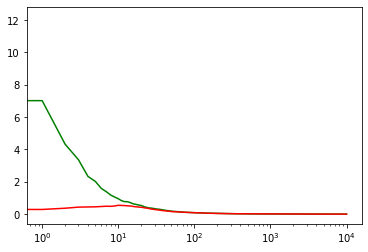

In [4]:
G0 = -0.27726 #From book

s0 = (13,2,1)

# Now use behavorial policy
def b(s):
  return np.random.rand()<.5

n_trials = 500
n_episodes = int(1e4)
ordinary = np.zeros((n_trials,n_episodes))
weighted = np.zeros((n_trials,n_episodes))
for trial in tqdm(range(n_trials)):
  my_sum = 0
  my_sum2 = 0
  for i in range(n_episodes):
    s = s0
    episode = []
    rho = 1
    terminal = False
    while not terminal:
      a = b(s)
      if a:
        rho *= (s[0]<20) / (1/2) # Target policy prob. divided by behavorial policy prob.
      else: 
        rho *= (s[0]>19) / (1/2) # Target policy prob. divided by behavorial policy prob.
      r,s,terminal = env.step(s,a)
    my_sum += rho*r
    my_sum2 += rho
    ordinary[trial,i] = my_sum / (i+1)
    if my_sum2 > 0:
      weighted[trial,i] = my_sum / my_sum2
ordinary_mse = np.sum((ordinary-G0)**2,axis=0)/n_trials
weighted_mse = np.sum((weighted-G0)**2,axis=0)/n_trials
plt.semilogx(ordinary_mse,"g")
plt.semilogx(weighted_mse,"r")


# Figure 5.4 

Ordinary importance sampling produces surprisingly unstable estimates on the
one-state MDP shown inset (Example 5.5). The correct estimate here is 1 ($\gamma$ = 1), and, even
though this is the expected value of a sample return (after importance sampling), the variance
of the samples is infinite, and the estimates do not converge to this value. These results are for
off-policy first-visit MC.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

(0.0, 2.0)

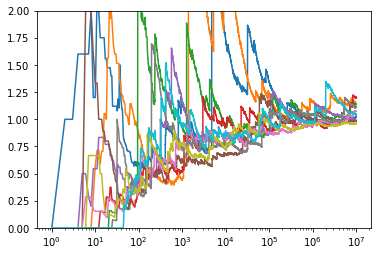

In [7]:
np.random.seed(0)

n_trials = 10
n_episodes = int(1e7)
ordinary = np.zeros((n_episodes,n_trials))
for trial in tqdm(range(n_trials)):
  my_sum = 0
  n_states = 0
  n_visits = 1
  for i in tqdm(range(n_episodes),leave=False):
    rhor = 1
    while True:
      if np.random.rand()<.5:
        rhor = 0
        break
      rhor *= 2
      if np.random.rand()>0.9:
        break   
      n_visits += 1
    my_sum += rhor
    ordinary[i,trial] = my_sum / n_visits
plt.semilogx(range(1,n_episodes+1),ordinary)
plt.ylim(0,2)

<IPython.core.display.Javascript object>


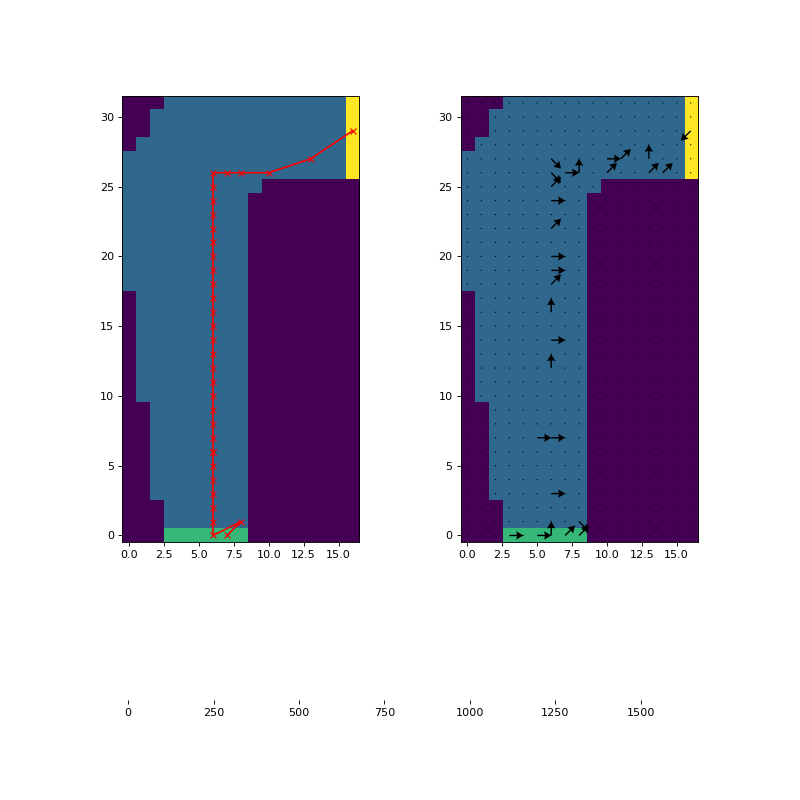

  2%|▏         | 1650/100000 [00:13<13:54, 117.91it/s]


KeyboardInterrupt: 

In [9]:
import env_racetrack
import experiment_mc_offpolicy
from importlib import reload
reload(env_racetrack)
reload(experiment_mc_offpolicy)
reload(policy)

def plot(i, episode):  
  global lens
  lens += [len(episode)]
  if i%50==0:
    x = [x for ((x,_,_,_),_,_) in episode]
    y = [y for ((_,y,_,_),_,_) in episode]
  
    ax1.clear()
    ax1.imshow(np.swapaxes(env.field,0,1),origin="lower")
    ax1.plot(x,y,'rx-')
    
    ax2.clear()
    ax2.imshow(np.swapaxes(env.field,0,1),origin="lower")
    arr_u = np.zeros((env.sx,env.sy))
    arr_v = np.zeros((env.sx,env.sy))
    for s in env.states:
      ax,ay = ag.pi.get(s)
      x,y,_,_ = s
      arr_u[x,y] += ax
      arr_v[x,y] += ay
    for x in range(env.sx):
      for y in range(env.sy):
        v = (arr_u[x,y]**2 + arr_v[x,y]**2)**.5
        if v>0:
          arr_u[x,y] /= v
          arr_v[x,y] /= v
    ax2.quiver(np.swapaxes(arr_u,0,1),np.swapaxes(arr_v,0,1),units='xy',angles='xy',scale=1,
               width=0.1,headwidth=6)
    
    ax3.clear()
    ax3.semilogy(lens,'.')
    
    fig.canvas.draw()

%matplotlib notebook
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
k = 4
ax1 = plt.subplot(k,2,(1,2*k-3))
ax2 = plt.subplot(k,2,(2,2*k-2))
ax3 = plt.subplot(k,2,(2*k-1,2*k))

env = env_racetrack.RacetrackEnvironment()
pi = policy.DeterministicPolicy(env=env,best_actions={s:[(0,0)] for s in env.states})
ag = agent.BaseAgent(env=env,pi=pi)
exp = MC_OffPolicyExperiment(env=env,agent=ag,n_episodes=1e5,q_init=-1e6,eps=0.01,callback=plot)
lens = []


fig.show()
fig.canvas.draw()

exp.train()